In [1]:
import pandas as pd
import math
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Introduction

Your submission should include the following: 


A description of your experimental setup. Any non-obvious choice should include a sentence or two for justification. This should include: 
1. The features you will include. 
2. Average acceleration for a user.
3. Average time between observations for a user.
4. How you will evaluate the performance of your model.
5. Modeling approach.

Implementation of your experiment. This should include:
1. the feature engineering, training, and evaluation code required to follow through on your experimental setup.

A brief note describing your findings. This should include: 
1. A 3 - 6 sentence summary (imagine a Slack post or email).
2. Any relevant tables or plots.

# Feature engineering

In [2]:
def add_magnitudes(user_data):
    """Add magnitude feature column"""
    for i in range (0,22):
        user_id = user_data[i]
        x2 = user_id['xAxis'] * user_id['xAxis']
        y2 = user_id['yAxis'] * user_id['yAxis']
        z2 = user_id['zAxis'] * user_id['zAxis']
        m2 = x2 + y2 + z2
        user_data[i]['magnitude'] = m2.apply(lambda x: math.sqrt(x))
        
def add_ave_acceleration_for_a_user(user_data):
    """Add average acceleration column. Requested by Viaduct.""" 
    for i in range (0,22):
        user_data[i]['ave_x_acceleration'] = user_data[i]['xAxis'].mean()
        user_data[i]['ave_y_acceleration'] = user_data[i]['yAxis'].mean()
        user_data[i]['ave_z_acceleration'] = user_data[i]['zAxis'].mean()

def add_ave_time_bw_observations(user_data):
    """Add average time between observations feature column. Requested by Viaduct."""
    for i in range (0,22):
        user_data[i]['ave_time_diff_bw_observations'] = user_data[i]['timestamp'].sort_values().diff().mean()
        
def window(axis,dx=100):
    """Function for defining the window on data"""
    start = 0
    size = axis.count()
    while (start < size):
        end = start + dx
        yield start,end
        start = start+int(dx/2)

def window_summary(axis, start, end):
    """Feature engineering."""
    acf = stattools.acf(axis[start:end])
    acv = stattools.acovf(axis[start:end])
    sqd_error = (axis[start:end] - axis[start:end].mean()) ** 2
    return [
        axis[start:end].mean(),
        axis[start:end].std(),
        axis[start:end].var(),
        axis[start:end].min(),
        axis[start:end].max(),
        acf.mean(), # mean auto correlation
        acf.std(), # standard deviation auto correlation
        acv.mean(), # mean auto covariance
        acv.std(), # standard deviation auto covariance
        skew(axis[start:end]),
        kurtosis(axis[start:end]),
        math.sqrt(sqd_error.mean())
    ]

def features(user_id):
    """Generator function creating features to iterate over."""
    for (start, end) in window(user_id['timestamp']):
        features = []
        for axis in ['xAxis', 'yAxis', 'zAxis', 'magnitude']:
            features += window_summary(user_id[axis], start, end)
        yield features

def feature_engineering():
    """Main feature engineering function."""
    COLUMNS = ['timestamp', 'xAxis', 'yAxis', 'zAxis']
    user_data = []

    for i in range (1,23):
        file_path = 'User Identification From Walking Activity/'+str(i)+'.csv'
        user_data.append((pd.read_csv(file_path,header=None,names=COLUMNS))[:911]) 
        # 911 is the min([len(user_data[i]) for i in range(len(user_data))])

    add_magnitudes(user_data) # Add magnitude column
    add_ave_acceleration_for_a_user(user_data)
    add_ave_time_bw_observations(user_data)
    
    #Write the feature vectors to a separate excel file
    with open('features.csv', 'w') as out:
        rows = csv.writer(out)
        for i in range(0, len(user_data)):
            for f in features(user_data[i]):
                rows.writerow([i]+f)    

feature_engineering()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:372: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


# Training

In [3]:
dataset = np.loadtxt('User Identification From Walking Activity/features.csv', delimiter=",",skiprows=1)

X = dataset[:, 1:] # Shape (480, 48)
y = dataset[:, 0] # Shape (480,)
class_names = ['user-1','user-2','user-3','user-4','user-5','user-6','user-7','user-8','user-9','user-10','user-11','user-12','user-13','user-14','user-15','user-16','user-17','user-18','user-19','user-20','user-21','user-22']

classifiers = {'Baseline Classifier':DummyClassifier(),'Random Forest Classifier':RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1), 'KNN':KNeighborsClassifier(10),'Decision Tree':DecisionTreeClassifier(max_depth=6),'Linear SVM':SVC(kernel="linear", C=0.025),'RBF SVM':SVC(gamma=2, C=1)}
classifiers_title = list(classifiers.keys())               
scores=np.empty(10)
means_scores, stddev_scores, y_preds=[], [], []

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4)

#Performing classification using each classifier and computing the 10-Fold cross-validation on results
for i in range(classifiers.__len__()):
    classifiers[classifiers_title[i]].fit (X_train,y_train)
    y_pred = classifiers[classifiers_title[i]].predict(X_test)
    y_preds.append(y_pred)
    scores = cross_val_score(classifiers[classifiers_title[i]],X,y,cv=10)
    mean = scores.mean()
    stdev = scores.std()
    means_scores.append(mean)
    stddev_scores.append(stdev)
    print(f"[Results For {classifiers_title[i]} ] Mean: {mean} Std Dev: {stdev}")

/usr/local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


[Results For Baseline Classifier ] Mean: 0.0375 Std Dev: 0.03333333333333333
[Results For Random Forest Classifier ] Mean: 0.5416666666666666 Std Dev: 0.19184774055368894
[Results For KNN ] Mean: 0.55625 Std Dev: 0.20092019214382387
[Results For Decision Tree ] Mean: 0.4645833333333333 Std Dev: 0.15395537322368597
[Results For Linear SVM ] Mean: 0.6270833333333333 Std Dev: 0.20570213429995216
[Results For RBF SVM ] Mean: 0.14375 Std Dev: 0.06417884083645568


# Evaluation 

In [4]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """Helper function for computing and plotting the confusion matrix."""
    plt.imshow(cm, interpolation='nearest', cmap=cmap,aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2))+'%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def autolabel(rects):
    """Helper function for labelling bar charts"""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % float(height),
                ha='center', va='bottom')

## Any relevant tables or plots.

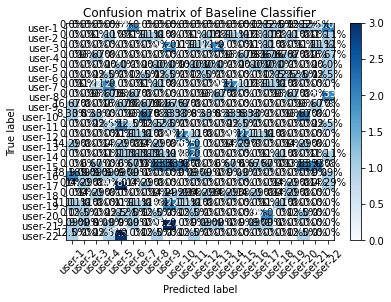

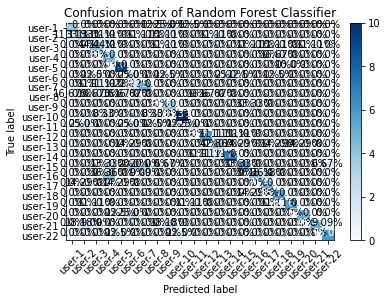

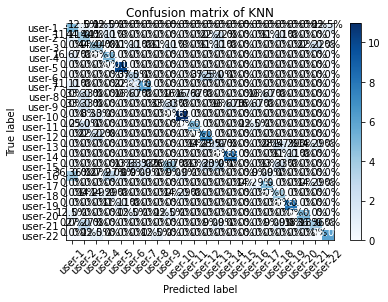

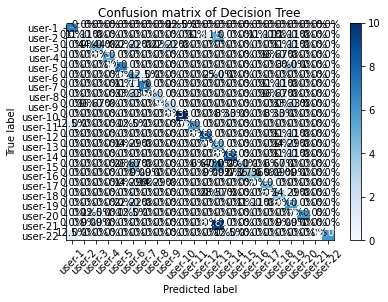

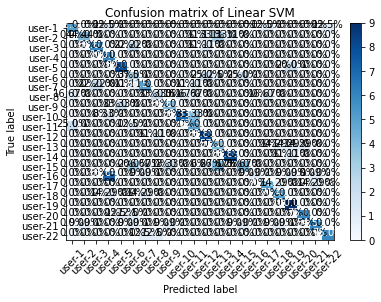

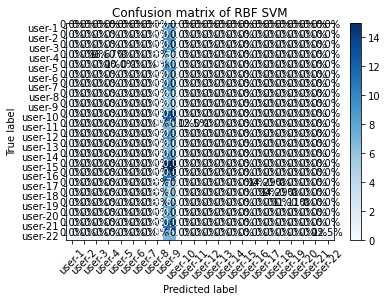

In [5]:
#Performing classification using each classifier and computing the 10-Fold cross-validation on results
for i in range(classifiers.__len__()):
    cnf_matrix = confusion_matrix(y_test, y_preds[i])
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title=('Confusion matrix of ' + classifiers_title[i]))

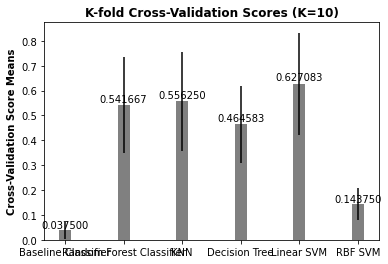

In [6]:
# plotting the bar chart showing each classifier's mean and std deviation of cross-validation score
fig,ax= plt.subplots()
rect1 = ax.bar(np.arange(6),means_scores,0.2,color='gray',yerr=stddev_scores)
ax.set_title('K-fold Cross-Validation Scores (K=10)',weight='bold')
ax.set_ylabel('Cross-Validation Score Means',weight='bold')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(classifiers_title)
autolabel(rect1)

0.609375

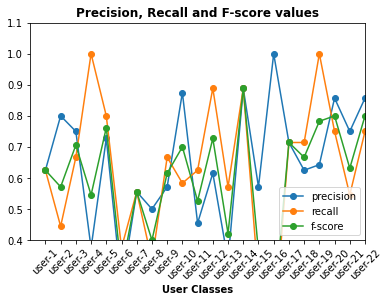

In [7]:
#calculating the precision, recall, fscore and support for the best classifier i.e. Linear SVM
y_pred = classifiers['Linear SVM'].predict(X_test)
prec_rec_fscore_supt = precision_recall_fscore_support(y_test,y_pred)

#plotting precision,recall and fscore values for each class of users
fig,ax = plt.subplots()
x= np.arange(1,23)
ax.plot(x,prec_rec_fscore_supt[0],'o-')
ax.plot(x,prec_rec_fscore_supt[1],'o-')
ax.plot(x,prec_rec_fscore_supt[2],'o-')

ax.set_ylim(0.4,1.1)
ax.set_xlim(0,22)
ax.legend(['precision','recall','f-score'],loc='lower right')
ax.set_xlabel ('User Classes',weight='bold')
ax.set_title ('Precision, Recall and F-score values',weight='bold')

plt.xticks(x, class_names, rotation=45) 

accuracy_score(y_test, y_pred)

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62         8
         1.0       0.80      0.44      0.57         9
         2.0       0.75      0.67      0.71         9
         3.0       0.38      1.00      0.55         6
         4.0       0.73      0.80      0.76        10
         5.0       0.25      0.38      0.30         8
         6.0       0.56      0.56      0.56         9
         7.0       0.50      0.33      0.40         6
         8.0       0.57      0.67      0.62         6
         9.0       0.88      0.58      0.70        12
        10.0       0.45      0.62      0.53         8
        11.0       0.62      0.89      0.73         9
        12.0       0.33      0.57      0.42         7
        13.0       0.89      0.89      0.89         9
        14.0       0.57      0.27      0.36        15
        15.0       1.00      0.09      0.17        11
        16.0       0.71      0.71      0.71         7
        17.0       0.62    

## Summary
A 3 - 6 sentence summary (imagine a Slack post or email).

Hey team, I just spent a couple hours training and evaluating a model for identifying users from their wearable device data.

Data: The models were trained on the "User Identification From Walking Activity Data Set", and I feature engineered average acceleration for a user, average time between observations for a user, amd more.

Models: I created 6 machine learning classifiers from simple to more complex: Baseline Dummy, Random Forest, KNN, Decision Tree, Linear SVM, and RBF SVM. I chose these machine learning models because they was able to implement them all using the same sklearn training framework, which allowed me to compare the accuracies, and because there wasn't enough data for deep learning models.

Main takeaways: The Linear SVM model performed the best, and feature engineering had a positive impact on the results. Scores were similar across different users, but User 18 had a uniquely low F1 score.

Future work: Hyperparameter tuning of models, more feature engineering, data augmentation, more evaluation using multiclass evaluation methods specific to each class

Concerns: The training data was Android only. We will need to test how our model generalizes to iPhones using a different test set.